In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline


In [49]:
df = pd.read_csv(r'D:\OneDrive\Documents\IIT\STAGE 02\Machine Learning\CW\data\processed\telco_data_cleaned.csv') 
df.head()

,SeniorCitizen,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_0–12,tenure_group_13–24,tenure_group_25–36,tenure_group_37–48,tenure_group_49–60,tenure_group_61–72
0,False,29.85,29.85,0,True,False,False,True,True,False,...,False,False,True,False,True,False,False,False,False,False
1,False,56.95,1889.50,0,False,True,True,False,True,False,...,False,False,False,True,False,False,True,False,False,False
2,False,53.85,108.15,1,False,True,True,False,True,False,...,False,False,False,True,True,False,False,False,False,False
3,False,42.30,1840.75,0,False,True,True,False,True,False,...,True,False,False,False,False,False,False,True,False,False
4,False,70.70,151.65,1,True,False,True,False,True,False,...,False,False,True,False,True,False,False,False,False,False


In [50]:
# split features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

In [51]:
# SMOTE for balancing classes
sm = SMOTE(sampling_strategy='auto')
X_resampled, y_resampled = sm.fit_resample(X, y)


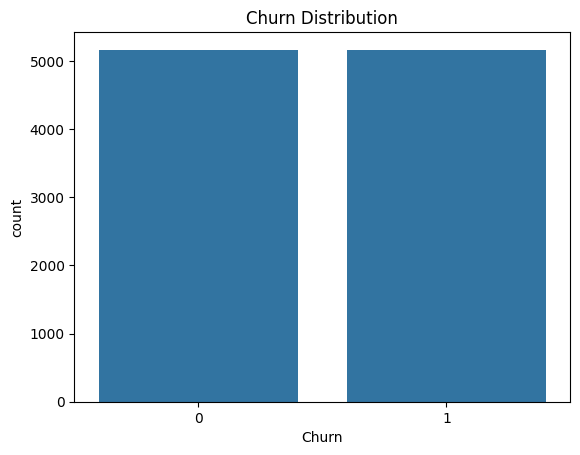

In [52]:
# Visualize the class distribution after resampling
sns.countplot(x=y_resampled)
plt.title('Churn Distribution')
plt.show()

In [53]:
# Stratified split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)


In [54]:
# Scale numerical features
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns  # Identify numerical columns

scaler = StandardScaler()
X_resampled[numerical_cols] = scaler.fit_transform(X_resampled[numerical_cols]) # Fit and transform on training data
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])


In [55]:
# Decision Tree Classifier
dt_classifier= DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=8, min_samples_split=10, random_state=100)
dt_classifier.fit(X_resampled, y_resampled) # Fit on resampled training data

DecisionTreeClassifier(max_depth=10, min_samples_leaf=8, min_samples_split=10,
                       random_state=100)

In [56]:
# Predictions
y_pred_dt = dt_classifier.predict(X_test)

In [57]:
# Evaluate model
dt_classifier.score(X_test, y_test)
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Classification Report:\n", classification_report(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))


Accuracy: 0.8688286544046466
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87      1033
           1       0.88      0.85      0.87      1033

    accuracy                           0.87      2066
   macro avg       0.87      0.87      0.87      2066
weighted avg       0.87      0.87      0.87      2066

Confusion Matrix:
 [[913 120]
 [151 882]]


In [58]:
# Hyperparameter tuning with GridSearchCV
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('smoteenn', SMOTE()),
    ('model', DecisionTreeClassifier())
])

In [59]:
# Hyperparameter tuning with GridSearchCV
param_grid = {
    'model__max_depth': [3, 5, 7, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 5],
    'model__criterion': ['gini', 'entropy']
}

In [60]:
# Perform Grid Search
grid_dt = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,                 # 5-fold cross-validation
    scoring='f1',         # Focus on minority class performance
    n_jobs=-1
)

grid_dt.fit(X_resampled, y_resampled)



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('smoteenn', SMOTE()),
                                       ('model', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [3, 5, 7, None],
                         'model__min_samples_leaf': [1, 2, 5],
                         'model__min_samples_split': [2, 5, 10]},
             scoring='f1')

In [61]:
# Get best  model and make predictions
best_dt = grid_dt.best_estimator_
y_pred = best_dt.predict(X_resampled)

In [62]:
# Metrics for fine-tuned model
print("Best DT parameters:", grid_dt.best_params_)
print("Best CV F1-score:", grid_dt.best_score_)

Best DT parameters: {'model__criterion': 'entropy', 'model__max_depth': 7, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5}
Best CV F1-score: 0.8057461771461891


In [63]:
# Evaluate fine-tuned model
print("Accuracy:", accuracy_score(y_resampled, y_pred))
print("Classification Report:\n", classification_report(y_resampled, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_resampled, y_pred))



Accuracy: 0.8392407515010653
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.85      0.84      5163
           1       0.85      0.83      0.84      5163

    accuracy                           0.84     10326
   macro avg       0.84      0.84      0.84     10326
weighted avg       0.84      0.84      0.84     10326

Confusion Matrix:
 [[4388  775]
 [ 885 4278]]


## Neural Network

In [64]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from kerastuner.tuners import Hyperband


C:\Users\A S U S\AppData\Local\Temp\ipykernel_14492\255494342.py:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


In [65]:
# Define model
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_resampled.shape[1],)),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # sigmoid for binary classification
])


d:\OneDrive\Documents\IIT\STAGE 02\Machine Learning\CW\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [66]:
# Compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [67]:
# Train model with early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(X_resampled, y_resampled,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=32,
                    callbacks=[early_stop])


Epoch 1/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7426 - loss: 0.5300 - val_accuracy: 0.7836 - val_loss: 0.5845
Epoch 2/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7691 - loss: 0.4736 - val_accuracy: 0.8698 - val_loss: 0.4098
Epoch 3/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7858 - loss: 0.4560 - val_accuracy: 0.8761 - val_loss: 0.3830
Epoch 4/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7923 - loss: 0.4443 - val_accuracy: 0.8916 - val_loss: 0.3679
Epoch 5/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7952 - loss: 0.4360 - val_accuracy: 0.8582 - val_loss: 0.4223
Epoch 6/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8022 - loss: 0.4250 - val_accuracy: 0.9395 - val_loss: 0.2452
Epoch 7/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8052 - loss: 0.4184 - val_accuracy: 0.9134 - val_loss: 0.3067
Epoch 8/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8136 - loss: 0.4117 - val_accuracy: 0.

In [68]:
# Evaluate model
y_pred_proba = model.predict(X_test)
# ---- 2. Convert probabilities to class labels (0 or 1) ----
y_pred = (y_pred_proba > 0.5).astype(int)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test Accuracy: 0.8620522749273959

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1033
           1       0.89      0.83      0.86      1033

    accuracy                           0.86      2066
   macro avg       0.86      0.86      0.86      2066
weighted avg       0.86      0.86      0.86      2066


Confusion Matrix:
 [[928 105]
 [180 853]]


In [69]:
# Hyperparameter tuning with Keras Tuner
def build_model(hp):
    model = Sequential()

    # Number of neurons in first layer
    model.add(Dense(
        units = hp.Int('units_1', min_value=16, max_value=128, step=16),
        activation='relu',
        input_shape=(X_resampled.shape[1],)
    ))
    
    # Optional dropout
    model.add(Dropout(hp.Float('dropout_1', 0.0, 0.5, step=0.1)))

    # Second hidden layer (tunable units)
    model.add(Dense(
        units = hp.Int('units_2', min_value=16, max_value=128, step=16),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout_2', 0.0, 0.5, step=0.1)))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Tune learning rate
    lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


In [70]:
# Initialize Keras Tuner
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='tuner_results',
    project_name='churn_nn'
)


Reloading Tuner from tuner_results\churn_nn\tuner0.json


In [71]:
# hyperparameter search
tuner.search(
    X_resampled, y_resampled,
    epochs=20,
    validation_split=0.2
)



In [72]:
best_hp = tuner.get_best_hyperparameters(1)[0]
print(best_hp.values)



{'units_1': 80, 'dropout_1': 0.0, 'units_2': 64, 'dropout_2': 0.30000000000000004, 'learning_rate': 0.002952274106645383, 'tuner/epochs': 7, 'tuner/initial_epoch': 3, 'tuner/bracket': 2, 'tuner/round': 1, 'tuner/trial_id': '0008'}


In [73]:
# Get the best model
best_model = tuner.get_best_models(1)[0]


d:\OneDrive\Documents\IIT\STAGE 02\Machine Learning\CW\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
d:\OneDrive\Documents\IIT\STAGE 02\Machine Learning\CW\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [74]:
# Retrain best model
history = best_model.fit(
    X_resampled, y_resampled,
    validation_split=0.2,
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)]
)


Epoch 1/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8127 - loss: 0.4092 - val_accuracy: 0.9076 - val_loss: 0.2217
Epoch 2/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8156 - loss: 0.3836 - val_accuracy: 0.9613 - val_loss: 0.0779
Epoch 3/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8280 - loss: 0.3718 - val_accuracy: 0.9666 - val_loss: 0.0993
Epoch 4/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8264 - loss: 0.3678 - val_accuracy: 0.9579 - val_loss: 0.1295
Epoch 5/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8299 - loss: 0.3557 - val_accuracy: 0.9443 - val_loss: 0.1523
Epoch 6/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8333 - loss: 0.3560 - val_accuracy: 0.9729 - val_loss: 0.0609
Epoch 7/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8350 - loss: 0.3487 - val_accuracy: 0.9685 - val_loss: 0.0690
Epoch 8/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8341 - loss: 0.3470 - val_accuracy: 0.

In [75]:
test_loss, test_auc = best_model.evaluate(X_test, y_test)
print("Test AUC:", test_auc)


65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8635 - loss: 0.2843
Test AUC: 0.8635043501853943


In [76]:
# Evaluate best model
y_pred_proba = best_model.predict(X_test)
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)
# ---- 2. Convert probabilities to class labels (0 or 1) ----
y_pred = (y_pred_proba > 0.5).astype(int)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8635 - loss: 0.2843
Test Accuracy: 0.8635043501853943
Test Accuracy: 0.8635043562439496

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.92      0.87      1033
           1       0.91      0.80      0.85      1033

    accuracy                           0.86      2066
   macro avg       0.87      0.86      0.86      2066
weighted avg       0.87      0.86      0.86      2066


Confusion Matrix:
 [[954  79]
 [203 830]]
